# **Business Running Case: Evaluating Personal Job Market Prospects in 2024**

In [2]:
import polars as pl
import pandas as pd
import sqlite3
import plotly.express as px
import missingno as msno

In [3]:
df = pd.read_csv("lightcast_job_postings.csv")

In [4]:
df.head()

,ID,LAST_UPDATED_DATE,LAST_UPDATED_TIMESTAMP,DUPLICATES,POSTED,EXPIRED,DURATION,SOURCE_TYPES,SOURCES,URL,...,NAICS_2022_2,NAICS_2022_2_NAME,NAICS_2022_3,NAICS_2022_3_NAME,NAICS_2022_4,NAICS_2022_4_NAME,NAICS_2022_5,NAICS_2022_5_NAME,NAICS_2022_6,NAICS_2022_6_NAME
0,1f57d95acf4dc67ed2819eb12f049f6a5c11782c,2024-09-06,2024-09-06 20:32:57.352 Z,0,2024-06-02,2024-06-08,6.0,"[\n ""Company""\n]","[\n ""brassring.com""\n]","[\n ""https://sjobs.brassring.com/TGnewUI/Sear...",...,44,Retail Trade,441,Motor Vehicle and Parts Dealers,4413,"Automotive Parts, Accessories, and Tire Retailers",44133,Automotive Parts and Accessories Retailers,441330,Automotive Parts and Accessories Retailers
1,0cb072af26757b6c4ea9464472a50a443af681ac,2024-08-02,2024-08-02 17:08:58.838 Z,0,2024-06-02,2024-08-01,NaN,"[\n ""Job Board""\n]","[\n ""maine.gov""\n]","[\n ""https://joblink.maine.gov/jobs/1085740""\n]",...,56,Administrative and Support and Waste Managemen...,561,Administrative and Support Services,5613,Employment Services,56132,Temporary Help Services,561320,Temporary Help Services
2,85318b12b3331fa490d32ad014379df01855c557,2024-09-06,2024-09-06 20:32:57.352 Z,1,2024-06-02,2024-07-07,35.0,"[\n ""Job Board""\n]","[\n ""dejobs.org""\n]","[\n ""https://dejobs.org/dallas-tx/data-analys...",...,52,Finance and Insurance,524,Insurance Carriers and Related Activities,5242,"Agencies, Brokerages, and Other Insurance Rela...",52429,Other Insurance Related Activities,524291,Claims Adjusting
3,1b5c3941e54a1889ef4f8ae55b401a550708a310,2024-09-06,2024-09-06 20:32:57.352 Z,1,2024-06-02,2024-07-20,48.0,"[\n ""Job Board""\n]","[\n ""disabledperson.com"",\n ""dejobs.org""\n]","[\n ""https://www.disabledperson.com/jobs/5948...",...,52,Finance and Insurance,522,Credit Intermediation and Related Activities,5221,Depository Credit Intermediation,52211,Commercial Banking,522110,Commercial Banking
4,cb5ca25f02bdf25c13edfede7931508bfd9e858f,2024-06-19,2024-06-19 07:00:00.000 Z,0,2024-06-02,2024-06-17,15.0,"[\n ""FreeJobBoard""\n]","[\n ""craigslist.org""\n]","[\n ""https://modesto.craigslist.org/sls/77475...",...,99,Unclassified Industry,999,Unclassified Industry,9999,Unclassified Industry,99999,Unclassified Industry,999999,Unclassified Industry


In [5]:
print(df.shape)

(72476, 131)


# **📌 Data Cleaning & Preprocessing**

***Drop Unnecessary Columns***

In [6]:
columns_to_drop = [
    "ID", "URL", "ACTIVE_URLS", "DUPLICATES", "LAST_UPDATED_TIMESTAMP",
    "NAICS2", "NAICS3", "NAICS4", "NAICS5", "NAICS6",
    "SOC_2", "SOC_3", "SOC_5"
]
df.drop(columns=columns_to_drop, inplace=True)

*We are removing multiple versions of NAICS/SOC codes because we are going to use the most granular version of those codes available.*

*In this case it is NAICS and SOC codes. Keeping multiple versions would introduce redundancy and potential inconsistencies in our analysis.*

***The following columns are irrelevant or redundant for our analysis and can be dropped to improve efficiency and clarity.***

***ID*** - *unique identifier which is not relevant for analysis*

***URL*** - *job posting urls which is not relevant for analysis*

***ACTIVE_URLS*** - *active urls for job posting which is not relevant for analysis*

***DUPLICATES*** - *whether the job post is duplicate or not*

***LAST_UPDATED_TIMESTAMP*** - *timestamp when the job post was updated*

***NAICS2CS3, NAICS4, NAICS5, NAICS6, NAI***- *less granular versions of NAICS code (we only need NAICS)*

***SOC_2, SOC_3, SOC_5*** - *less granular versions of SOC codes (we only need SOC)*


***Dropping these columns will improve our analysis by:***

*- Reducing the size of the dataset*
*- Removing irrelevant information*
*- Improving the clarity and focus of our analysis by removing unnecessary details.*

***Handling Missing Values***

<Axes: >

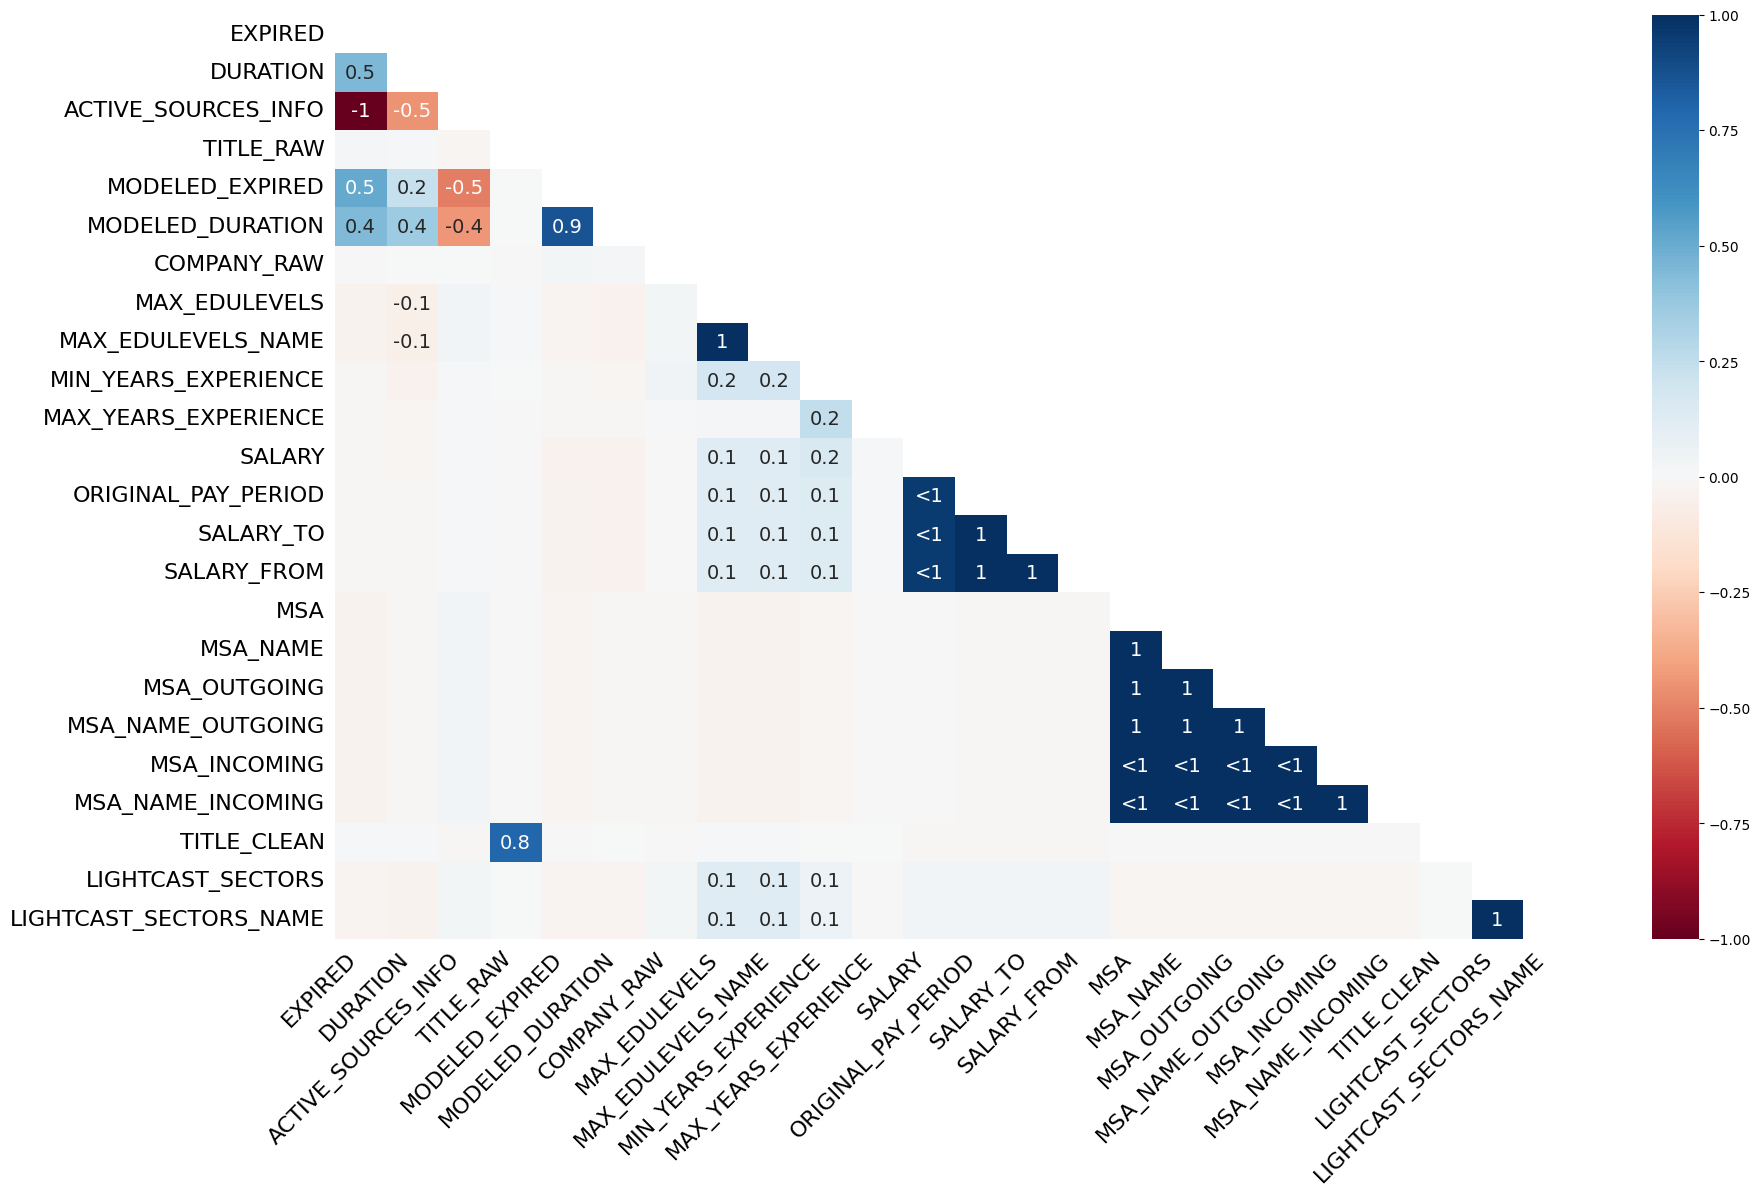

In [7]:
import missingno as msno
# Visualize missing data
msno.heatmap(df)

In [8]:
# Drop columns with >50% missing values
df.dropna(thresh=len(df) * 0.5, axis=1, inplace=True)

# Fill missing values safely
df["NAICS_2022_6"] = df["NAICS_2022_6"].fillna(df["NAICS_2022_6"].median())
df["NAICS_2022_6_NAME"] = df["NAICS_2022_6_NAME"].fillna("Unknown")


***Remove Duplicates***

*To ensure each job is counted only once, we remove duplicates based on job title, company, location, and posting date.*

In [9]:
df = df.drop_duplicates(subset=["TITLE", "COMPANY", "LOCATION", "POSTED"], keep="first")

# **📌 Exploratory Data Analysis (EDA)**

***Job Postings by Industry***

In [10]:
top_industries = df["NAICS_2022_6_NAME"].value_counts().nlargest(15)
fig = px.pie(
    names=top_industries.index, 
    values=top_industries.values, 
    title="Top 15 Job Posting Industries"
)
fig

***Top 20 Industries by Median Salary***

In [11]:
import plotly.express as px

# Compute median salary per industry
industry_salary = df.groupby("NAICS_2022_6_NAME")["NAICS_2022_6"].median().reset_index()

# Sort by median salary (highest first) and keep only top 10
industry_salary = industry_salary.sort_values(by="NAICS_2022_6", ascending=True).tail(10)

# Create an improved horizontal bar chart
fig = px.bar(
    industry_salary, 
    x="NAICS_2022_6", 
    y="NAICS_2022_6_NAME", 
    title="Top 20 Industries by Median Salary",
    labels={"NAICS_2022_6": "Median Salary ($)", "NAICS_2022_6_NAME": "Industry"},
    orientation="h",
    color="NAICS_2022_6",  # Color based on salary
    color_continuous_scale="viridis",  # More distinct colors
    height=800  # Increase figure height for readability
)

# Improve layout
fig.update_layout(
    yaxis=dict(title="Industry", tickmode="linear", tickfont=dict(size=12)), 
    xaxis=dict(title="Median Salary ($)", tickfont=dict(size=12)),
    margin=dict(l=200, r=20, t=50, b=50)  # Adjust margins for better spacing
)

fig


***Remote vs. On-Site Jobs***

In [12]:
fig = px.pie(df, names="REMOTE_TYPE_NAME", title="Remote vs. On-Site Jobs")
fig.show()

***Data-Related Job Postings Across the USA***

In [13]:
import plotly.express as px
import pandas as pd
import us  # To convert full state names to abbreviations

# 🔹 Step 1: Filter for Data-Related Roles
data_roles = df[df["NAICS_2022_6_NAME"].str.contains(
    "Data|Analytics|Machine Learning|Data Scientist|ML|Business Analyst|Data Analyst | ", 
    case=False, na=False
)]

# 🔹 Step 2: Aggregate Job Counts by State
job_counts = data_roles["STATE_NAME"].value_counts().reset_index()
job_counts.columns = ["state", "job_postings"]

# 🔹 Step 3: Convert Full State Names to Abbreviations
job_counts["state"] = job_counts["state"].apply(lambda x: us.states.lookup(x).abbr if us.states.lookup(x) else x)

# 🔹 Step 4: Create Choropleth Map
fig = px.choropleth(
    job_counts,
    locations="state",
    locationmode="USA-states",  # Correct location mode for US states
    color="job_postings",  # Color by job count
    hover_name="state",
    color_continuous_scale="Viridis",  # High-contrast color scheme
    title="Data-Related Job Postings Across the USA",
    scope="usa"  # Focus on the USA
)

fig.show()


Defaulting to user installation because normal site-packages is not writeable


***Industries related to data roles***

In [14]:
# Filter industries related to data roles
data_roles = df[df["NAICS_2022_6_NAME"].str.contains(
    "Data Analysts|Business Intelligence Analysts|Data Analytics Engineers|Data and Reporting Analysts|Data Governance Analysts|Data Quality Analysts|Data Analytics Analysts|Data Management Analysts|Data Modelers|Lead Data Analysts|Research Data Analysts|IT Data Analysts|Data Analytics Manager|Lead Business Intelligence Analysts|Data Science Analysts|Data Analytics Leads|Business Intelligence Data Analysts|Data Operations Analysts|Health Data Analysts|Data analytics consultants|Enterprise Data Analysts", 
    case=False, na=False
)]

# Get industries associated with these roles
industry_text = " ".join(data_roles["NAICS_2022_6_NAME"].dropna())

# Generate word cloud
wordcloud = WordCloud(
    width=800, height=400, background_color="white", 
    colormap="viridis", max_words=100
).generate(industry_text)

# Display the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Industries Having Data-Related Roles", fontsize=14)
plt.show()


NameError: name 'WordCloud' is not defined